In [1]:
import torch
from torch.utils.data import DataLoader,TensorDataset
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys
sys.path.append("..")
from torch import nn, optim
from torch.nn import functional as F
from src.datasets.dataset_wrappers import AugRepresentationDataset
from IPython.display import display,clear_output
import tqdm
from sklearn.metrics import normalized_mutual_info_score as nmi
import umap

In [2]:
#import the data
org = torch.load("../originals.pt")
aug = torch.load("../augmentations.pt")
labels = torch.load("../labels.pt")
nn_indices = torch.load("../nn_indices.pt")

dataset = AugRepresentationDataset(aug,org,labels)
dataloader = DataLoader(dataset,batch_size=5000,shuffle=True)


In [3]:
reducer = umap.UMAP(n_components=2,random_state=42,metric="cosine")
emb = reducer.fit_transform(org)


/home/alex/anaconda3/lib/python3.12/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


In [4]:
class PredictionHead(nn.Module):
    
    def __init__(self,in_dim,out_dim):
        super(PredictionHead,self).__init__()
        self.pred_head = nn.Sequential(
            nn.Linear(512,1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(),
            nn.Linear(1024,1024),
            nn.ReLU(),
            nn.Linear(1024,10)
        )
        
    def forward(self,x):
        return self.pred_head(x)
    

    
def ClusterLoss(p1,p2,z1,lamb=1.0,tau=1.0):

    p1,p2 = torch.softmax(p1,dim=1),torch.softmax(p2,dim=1)

    D,K = p1.shape
    D,R = z1.shape
    dot_term = - 1/D * torch.sum(torch.log(torch.sum(p1*p2,dim=(1))+1e-10))
    
    P = p1.mean(dim=0)
    entropy = torch.sum(P * torch.log(P + 1e-10))
    
    z_norm = F.normalize(z1,p=2,dim=1)

    sim = torch.exp(z_norm @ z_norm.T / tau)
    top_term = (sim.unsqueeze(2) * p1.unsqueeze(1)) # D,D,K
    bottom_term = (sim.unsqueeze(2).repeat(1,1,K)) # D,D,K
    
    var_term = top_term.sum(dim=(0,1)) / bottom_term.sum(dim=(0,1))
    var_term = - torch.log(var_term + 1e-10).mean()
    
    return dot_term,lamb*entropy,var_term

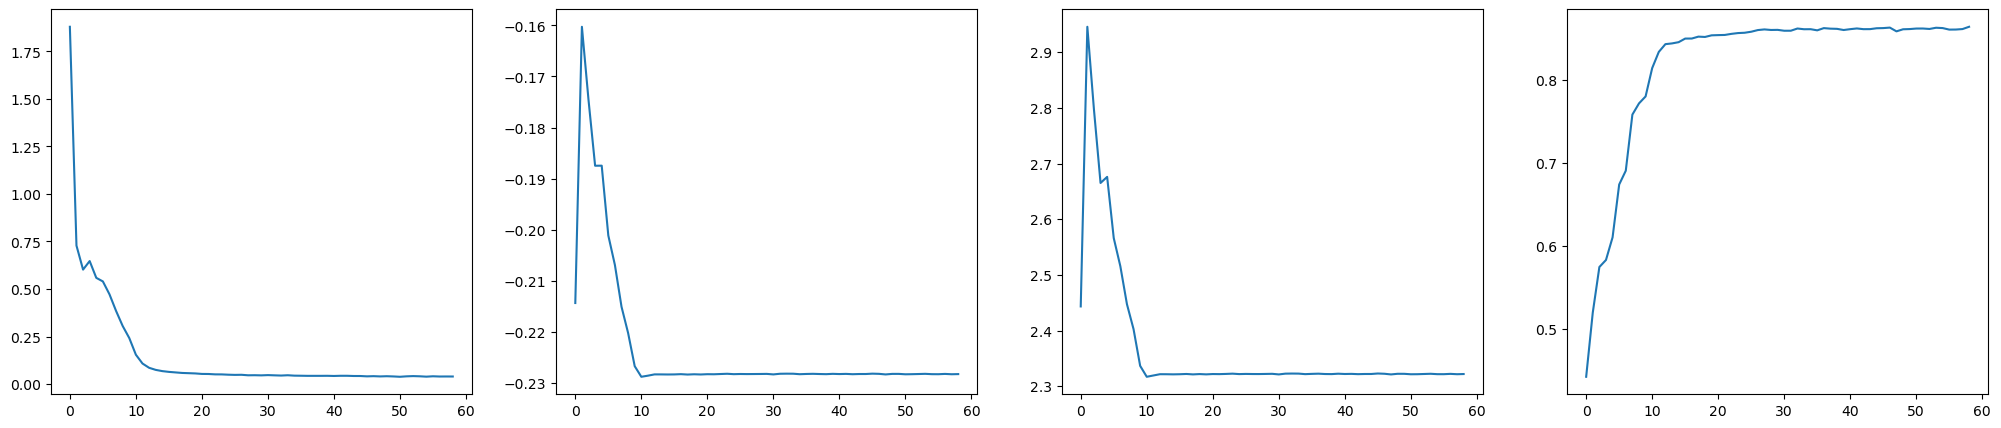

In [ ]:
dot_loss = []
ent_loss = []
var_loss = []
evals = []
model = PredictionHead(512,10)
device = 'cuda'
model.to(device)
optimizer = optim.Adam(model.parameters(),lr=0.0001)
f,a = plt.subplots(1,4,figsize=(25,5))

for epoch in range(100):
    temp_dot_loss = []
    temp_ent_loss = []
    temp_var_loss = []
    temp_eval = []
    for x1,x2,x,y in dataloader:

        optimizer.zero_grad()
        x1,x2 = x1.to(device),x2.to(device)
        p1,p2 = model(x1),model(x2)
        dot,ent,var = ClusterLoss(p1,p2,x1,lamb=0.1,tau=1.0)
        loss = dot + ent + var
        loss.backward()
        optimizer.step()
        temp_dot_loss.append(dot.item())
        temp_ent_loss.append(ent.item())
        temp_var_loss.append(var.item())
        temp_eval.append(nmi(y,p1.argmax(dim=1).cpu()))

    dot_loss.append(np.mean(temp_dot_loss))
    ent_loss.append(np.mean(temp_ent_loss))
    var_loss.append(np.mean(temp_var_loss))
    evals.append(np.mean(temp_eval))
    clear_output(wait=True)
    for ax in a: ax.clear()
    a[0].plot(dot_loss)
    a[1].plot(ent_loss)
    a[2].plot(var_loss)
    a[3].plot(evals)
    display(f)

<Axes: >

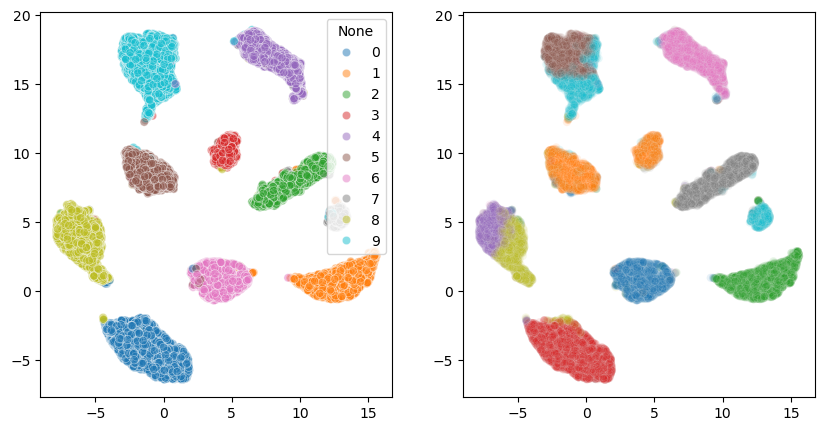

In [57]:
test_dataloader = DataLoader(dataset,batch_size=1000,shuffle=False)
pred_clus = []
with torch.no_grad():
    for x1,x2,x,y in test_dataloader:
        x1 = x1.to(device)
        p = model(x1)
        pred_clus.append(p.argmax(dim=1).cpu())
pred_clus = torch.cat(pred_clus)
f,a = plt.subplots(1,2,figsize=(10,5))
sns.scatterplot(x=emb[:,0],y=emb[:,1],hue=labels,palette="tab10",alpha=0.5,ax=a[0],legend=True)
sns.scatterplot(x=emb[:,0],y=emb[:,1],hue=pred_clus,palette="tab10",alpha=0.1,ax=a[1],legend=False)

In [12]:
#get the representations by labels
reps = [F.normalize(org[labels==i],p=2,dim=1) for i in range(10)]


In [26]:
sim27 = (reps[2] @ reps[7].T)
sim22 = (reps[2] @ reps[2].T)
sim77 = (reps[7] @ reps[7].T)

In [27]:
sim27.mean(),sim22.mean(),sim77.mean()

(tensor(0.6576), tensor(0.7939), tensor(0.8823))